In [5]:
import gudhi
import numpy as np

from functions.data_loading import get_filtered_data_range, get_data_range, get_flight_persistence, get_removed_outliers
from functions.data_filtering import complete_flight_filter
from functions.data_filtering import filter_by_bools, filter_flights

from datetime import datetime
from collections import Counter
from tqdm import tqdm
from traffic.core import Traffic, Flight

In [6]:
origin = "bergen"
destination = "oslo"

unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1))
filtered_flights, file_name = get_filtered_data_range(unfiltered_flights, file_name, complete_flight_filter(origin, destination, 0.75))
#fixed_flights, file_name = get_removed_outliers(filtered_flights, file_name)
persistences, file_name = get_flight_persistence(filtered_flights, file_name)

In [7]:
circly_flights=[]
for i, tree in enumerate(persistences):
    persistence = tree.persistence()

    more_than_00001 = len([x for x in persistence if  x[0] == 1 and x[1][1] - x[1][0] > 0.0001])
    #more_than_00005 = len([x for x in persistence if  x[0] == 1 and x[1][1] - x[1][0] > 0.0005])
    if more_than_00001 > 0:
        circly_flights.append(i)

In [8]:
"""
codes = Counter()
for flight in circly_flights:
    codes.update(filtered_flights[flight].squawk)

codes
"""

'\ncodes = Counter()\nfor flight in circly_flights:\n    codes.update(filtered_flights[flight].squawk)\n\ncodes\n'

There is not really any trend with ICAO codes and cyclic flights, they seem to be mostly unique

In [22]:
bool_array = np.zeros(len(persistences))
for i in circly_flights:
    bool_array[i] = 1

loopy_flights = filter_flights(filter_by_bools(bool_array), filtered_flights)
loopy_flights_pers = list(filter(filter_by_bools(bool_array), persistences))
loopy_flights.map_leaflet()

Map(center=[60.27090908587474, 8.711997815204462], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [10]:
flight_amount = len(persistences)
condensed_distance_matrix = []

for i in tqdm(range(len(circly_flights))):
    for j in range(i+1, len(circly_flights)):
        tree_i = persistences[circly_flights[i]]
        tree_j = persistences[circly_flights[j]]
        #pers_i = [x for x in tree_i.persistence_intervals_in_dimension(1) if  x[1] - x[0] > 0.0001]
        #pers_j = [x for x in tree_j.persistence_intervals_in_dimension(1) if  x[1] - x[0] > 0.0001]
        pers_i = tree_i.persistence_intervals_in_dimension(1)
        pers_j = tree_j.persistence_intervals_in_dimension(1)
        dist = gudhi.bottleneck_distance(pers_i, pers_j, 0.0001)
        condensed_distance_matrix.append(dist)

100%|██████████| 50/50 [00:00<00:00, 429.45it/s]


In [11]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import sys
sys.setrecursionlimit(10000)

Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

clustering = fcluster(Z, t=10, criterion='maxclust', depth=1)

In [12]:
for i in range(1, len(np.unique(clustering))+1):
    print(f"{i}: {sum(clustering == i)}")

1: 4
2: 5
3: 9
4: 9
5: 5
6: 13
7: 1
8: 2
9: 1
10: 1


In [88]:
bool_array = clustering == 10

loopy_flight_cluster = filter_flights(filter_by_bools(bool_array), loopy_flights)
loopy_flight_cluster_pers = list(filter(filter_by_bools(bool_array), loopy_flights_pers))
print(len(loopy_flight_cluster))
loopy_flight_cluster.map_leaflet()

1


Map(center=[60.36569925342792, 8.835122702845746], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [89]:
loopy_flight_cluster[0].map_leaflet()

Map(center=[60.36569925342792, 8.835122702845746], controls=(ZoomControl(options=['position', 'zoom_in_text', …

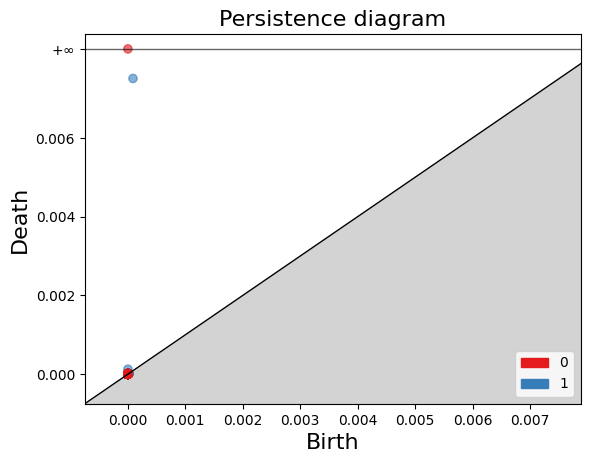

[None]

In [85]:
gudhi.plot_persistence_diagram(loopy_flight_cluster_pers[0].persistence())
[plt.show()]

* cluster 1: 2 cycles
* cluster 2: 1 cycle, 1 small cycle
* cluster 3: 1 cycle
* cluster 4: seemingly random?
* cluster 5: 1 small cycle
* cluster 6: 1 or multiple small cycles
* cluster 7: 1 cycle
* cluster 8: 1 large cycle
* cluster 9: 2 cycles
* cluster 10: 2 large cycles